# Playground

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

In [2]:
from typing import List, Set, Dict, Tuple, Optional, Any
from collections import defaultdict

import pandas as pd
import seaborn as sns
import numpy as np

import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution, Normal
from torch.utils.data import DataLoader, Dataset

from gmfpp.utils.data_preparation import *
from gmfpp.utils.data_transformers import *
from gmfpp.utils.plotting_nonvar import *
from gmfpp.utils.training import *

from gmfpp.models.ReparameterizedDiagonalGaussian import *
from gmfpp.models.CytoVariationalAutoencoder import *
#from gmfpp.models.VariationalAutoencoder import *
#from gmfpp.models.ConvVariationalAutoencoder import *
#from gmfpp.models.VariationalInference import *
from gmfpp.models.LoadModels import *

In [3]:
constant_seed()

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Load data

In [5]:
data_root = "./data/tiny/"
metadata_all = read_metadata(data_root + "metadata.csv")

mapping = get_MOA_mappings(metadata_all)

In [6]:
metadata = metadata_all[0:2]

In [7]:
metadata = shuffle_metadata(metadata)
metadata_train, metadata_validation = split_metadata(metadata, split_fraction = .90)
metadata_train, metadata_validation = metadata, metadata

In [8]:
relative_path = get_relative_image_paths(metadata)
image_paths = [data_root + path for path in relative_path]

In [9]:
images = load_images(image_paths, verbose=True, log_every=10000)

17:34:48 | loaded 0/2 images (0.00%).
17:34:48 | loaded 2/2 images (100.00%).


## Normalize data

In [10]:
normalize_every_image_channels_seperately_inplace(images)
#normalize_channels_inplace(images)

In [11]:
channel_first = view_channel_dim_first(images)
for i in range(channel_first.shape[0]):
    channel = channel_first[i]
    print("channel {} interval: [{:.2f}; {:.2f}]".format(i, torch.min(channel), torch.max(channel)))

channel 0 interval: [0.04; 1.00]
channel 1 interval: [0.15; 1.00]
channel 2 interval: [0.07; 1.00]


## Prepare datasets

In [12]:
class SingleCellDataset(Dataset):
    
    def __init__(self, metadata: pd.DataFrame, images: torch.Tensor, label_to_id: Dict[str, int]):
        self.metadata = metadata
        self.label_to_id = label_to_id
        self.images = images
        
    def __len__(self):
        return self.metadata.shape[0]

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        
        image_id = row.name
        image = self.images[image_id]
        
        label_name = row["moa"]
        label = self.label_to_id[label_name]
        
        return image.detach(), label

In [13]:
mapping = get_MOA_to_id()
train_set = SingleCellDataset(metadata_train, images, mapping)
validation_set = SingleCellDataset(metadata_validation, images, mapping)

In [14]:
len(train_set)

2

In [15]:
import numpy as np
from torch import nn, Tensor
import torch
from torch.distributions import Distribution, Exponential, Cauchy, HalfCauchy, Normal
from gmfpp.models.PrintSize import *
from typing import List, Set, Dict, Tuple, Optional, Any
from gmfpp.models.ReparameterizedDiagonalGaussian import ReparameterizedDiagonalGaussian

class CytoVariationalAutoencoder_nonvar(nn.Module):
   
    def __init__(self, input_shape, latent_features: int):
        super(CytoVariationalAutoencoder_nonvar, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        self.observation_shape = input_shape
        self.input_channels = input_shape[0]
        self.epsilon = 10e-3
        
        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            # now we are at 68h * 68w * 3ch
            nn.Conv2d(in_channels=self.input_channels, out_channels=32, kernel_size=5, padding=0),
            # Now we are at: 64h * 64w * 32ch
            nn.MaxPool2d(2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            # Now we are at: 32h * 32w * 32ch
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=0),
            # Now we are at: 28h * 28w * 32ch
            nn.MaxPool2d(2),
            # Now we are at: 14h * 14w * 32ch
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=0),
            # Now we are at: 10h * 10w * 32ch
            nn.MaxPool2d(2),
            # Now we are at: 5h * 5w * 32ch
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            ##Output should be 5*5*32 now.
            nn.Conv2d(in_channels=32, out_channels=2*256, kernel_size=5, padding=0),
            # Now we are at: 1h * 1w * 512ch
            nn.BatchNorm2d(2*256),
            nn.Flatten(),
        )

        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256,1,1)), # Now we are at: 1h * 1w * 256ch
            nn.Conv2d(in_channels=256, out_channels=32, kernel_size=5, padding=4),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.01),
            torch.nn.UpsamplingNearest2d(size=10),

            # Now we are at: 10h * 10w * 32ch
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=4),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.01),
            torch.nn.UpsamplingNearest2d(size=28),

            # Now we are at: 28h * 28w * 32ch
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=4),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.01),
            torch.nn.UpsamplingNearest2d(size=64),

            # Now we are at: 64h * 64w * 32ch
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=4),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.01),
            
            # Now we are at: 68h * 68w * 32ch
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=1, padding=0), # 6 channels because 3 for mean and 3 for variance
#            nn.BatchNorm2d(6),
            nn.LeakyReLU(negative_slope=0.01)
        )
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        
        mu, log_sigma =  h_x.chunk(2, dim=-1)

        #log_sigma = torch.maximum(log_sigma, torch.ones_like(log_sigma) * -10)
        log_sigma=torch.nn.functional.leaky_relu(log_sigma, negative_slope=0.01)
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma, epsilon=self.epsilon)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)

    def observation(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        mu = self.decoder(z)
        mu = mu.view(-1, *self.input_shape) # reshape the output
        #log_sigma = log_sigma.view(-1, *self.input_shape) # reshape the output
        return mu

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()

        # define the observation model p(x|z) = B(x | g(z))
        x_hat = self.observation(z)
        
        return {'x_hat': x_hat, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        x_hat = self.observation(z)
        
        return {'x_hat': x_hat, 'pz': pz, 'z': z}


In [16]:

def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    flat = view_flat_samples(x)
    return flat.sum(dim=1)

class VariationalInference_nonvar(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        self.loss = nn.MSELoss(reduction='none')
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        outputs = model(x)

        x_hat, pz, qz, z = [outputs[k] for k in ["x_hat", "pz", "qz", "z"]]
        mse_loss = ((x_hat - x)**2).mean(axis=[1,2,3])
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        kl = log_qz - log_pz
        #elbo = log_px - kl
        beta_elbo = -mse_loss - self.beta*kl
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': beta_elbo, 'mse_loss':mse_loss, 'kl': kl}
            
        return loss, diagnostics, outputs
      


## VAE

In [17]:
def initVAEmodel(latent_features= 256,
                    beta = 1.,
                    num_epochs = 1000,
                    batch_size = 32,
                    learning_rate = 1e-3,
                    weight_decay = 10e-4,
                    image_shape = np.array([3, 68, 68])):

    VAE_settings = {
        'latent_features' : latent_features,
        'beta' : beta,
        'num_epochs' : num_epochs,
        'batch_size' : batch_size,
        'learning_rate' : learning_rate,
        'weight_decay' : weight_decay,
        'image_shape' : image_shape
        }
        
    training_performance = defaultdict(list)
    validation_performance = defaultdict(list)

    vae = CytoVariationalAutoencoder_nonvar(VAE_settings['image_shape'], VAE_settings['latent_features'])
    return vae, validation_performance, training_performance, VAE_settings

In [18]:
# start another training session
_, validation_data, training_data, VAE_settings = initVAEmodel(latent_features= 256,
                                                                    beta = 1.,
                                                                    num_epochs = 1000,
                                                                    batch_size = min(32, len(train_set)),
                                                                    learning_rate = 1e-3,
                                                                    weight_decay = 10e-4,
                                                                    image_shape = np.array([3, 68, 68]))

In [19]:
vae = CytoVariationalAutoencoder_nonvar(np.array([3, 68, 68]), 256)
vae = vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=VAE_settings['learning_rate'], weight_decay=VAE_settings['weight_decay'])

vi = VariationalInference_nonvar(beta=VAE_settings['beta'])
batch_size = 2

In [20]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
validation_loader = DataLoader(validation_set, batch_size=len(validation_set), shuffle=False, num_workers=0, drop_last=False)
train_batcher = TreatmentBalancedBatchGenerator(images, metadata_train)

## Unbalanced training

In [21]:
print_every = 100

num_epochs = VAE_settings['num_epochs']
batch_size = VAE_settings['batch_size']

for epoch in range(num_epochs):

    training_epoch_data = defaultdict(list)
    
    vae.train()

    for x, _ in train_loader:
        x = x.to(device)
        
        loss, diagnostics, outputs = vi(vae, x)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(vae.parameters(), 10_000)
        optimizer.step()

        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]


    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    with torch.no_grad():
        vae.eval()
        
        validation_epoch_data = defaultdict(list)
        
        for x, _ in validation_loader:
            x = x.to(device)
          
            loss, diagnostics, outputs = vi(vae, x)
            
            for k, v in diagnostics.items():
                validation_epoch_data[k] += [v.mean().item()]

        for k, v in diagnostics.items():
            validation_data[k] += [np.mean(validation_epoch_data[k])]
        
    if epoch % print_every == 0:
        print(f"epoch: {epoch}/{num_epochs}")  
        print("training | elbo: {:2f}, mse_loss: {:.4f}, kl: {:.2f}:".format(np.mean(training_epoch_data["elbo"]), np.mean(training_epoch_data["mse_loss"]), np.mean(training_epoch_data["kl"])))
        print("validation | elbo: {:2f}, mse_loss: {:.4f}, kl: {:.2f}:".format(np.mean(validation_data["elbo"]), np.mean(validation_data["mse_loss"]), np.mean(validation_data["kl"])))    


epoch: 0/1000
training | elbo: -423.695282, mse_loss: 0.1707, kl: 423.52:
validation | elbo: -0.380035, mse_loss: 0.1252, kl: 0.25:
epoch: 100/1000
training | elbo: -337.553345, mse_loss: 0.0038, kl: 337.55:
validation | elbo: -98.391420, mse_loss: 0.0312, kl: 98.36:
epoch: 200/1000
training | elbo: -237.315094, mse_loss: 0.0013, kl: 237.31:
validation | elbo: -115.657723, mse_loss: 0.0187, kl: 115.64:
epoch: 300/1000
training | elbo: -196.394806, mse_loss: 0.0010, kl: 196.39:
validation | elbo: -109.371020, mse_loss: 0.0143, kl: 109.36:
epoch: 400/1000
training | elbo: -146.929672, mse_loss: 0.0009, kl: 146.93:
validation | elbo: -102.057863, mse_loss: 0.0119, kl: 102.05:
epoch: 500/1000
training | elbo: -128.851822, mse_loss: 0.0005, kl: 128.85:
validation | elbo: -94.157978, mse_loss: 0.0102, kl: 94.15:
epoch: 600/1000
training | elbo: -132.865204, mse_loss: 0.0006, kl: 132.86:
validation | elbo: -86.709218, mse_loss: 0.0090, kl: 86.70:
epoch: 700/1000
training | elbo: -98.765366, m

## Balanced treatment training

In [ ]:
iterations = 10_000

validate_every = 100

for iteration in range(iterations):
    x, _ = train_batcher.next_batch()
    
    vae.train()
    
    loss, diagnostics, outputs = vi(vae, x)

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(vae.parameters(), 10_000)
    optimizer.step()
    
    if iteration % validate_every == 0:
        with torch.no_grad():
            vae.eval()

            validation_epoch_data = defaultdict(list)

            for x, _ in validation_loader:
                x = x.to(device)

                loss, diagnostics, outputs = vi(vae, x)

                for k, v in diagnostics.items():
                    validation_epoch_data[k] += [v.mean().item()]

            for k, v in diagnostics.items():
                validation_data[k] += [np.mean(validation_epoch_data[k])]
        
        print(f"iteration: {iteration}/{iterations}")  
        print("validation | elbo: {:2f}, log_px: {:.2f}, kl: {:.2f}:".format(np.mean(validation_data["elbo"]), np.mean(validation_data["log_px"]), np.mean(validation_data["kl"])))    

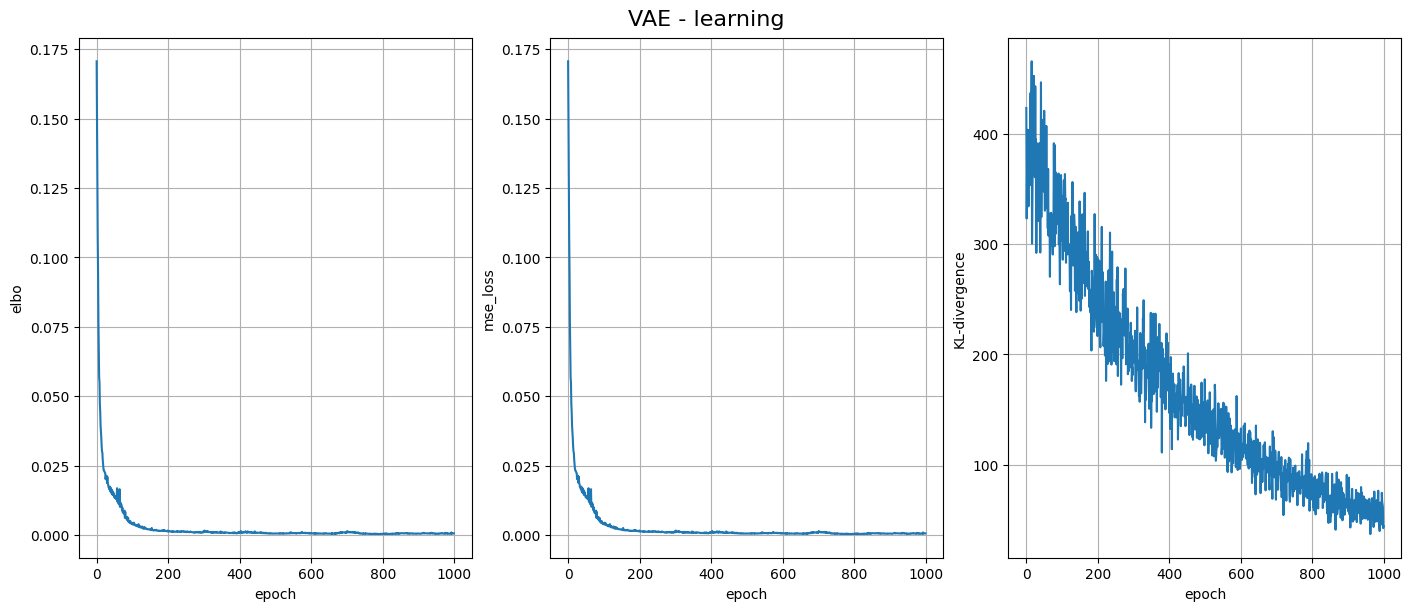

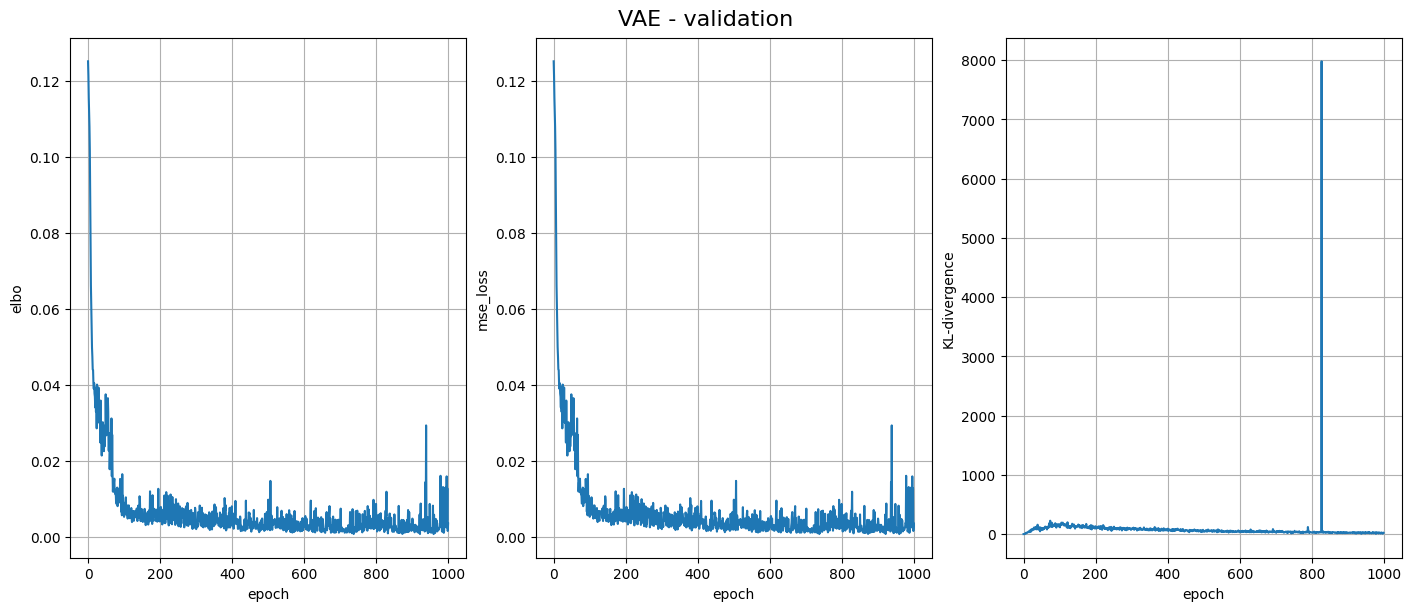

In [22]:
plot_VAE_performance(**training_data, title='VAE - learning')
plot_VAE_performance(**validation_data, title='VAE - validation')


In [23]:
treatment_indices = get_treatment_indices(metadata)

batcher = TreatmentBalancedBatchGenerator(treatment_indices, images, metadata)

TypeError: TreatmentBalancedBatchGenerator.__init__() takes 3 positional arguments but 4 were given

In [24]:
print(VAE_settings)

{'latent_features': 256, 'beta': 1.0, 'num_epochs': 1000, 'batch_size': 2, 'learning_rate': 0.001, 'weight_decay': 0.001, 'image_shape': array([ 3, 68, 68])}


In [49]:
######### Save VAE parameters #########
cprint("Save VAE parameters")
create_directory("dump/parameters")
datetime = get_datetime()
torch.save(vae.state_dict(), "dump/parameters/vae_parameters_{}.pt".format(datetime))
torch.save(validation_data, "dump/parameters/validation_data_{}.pt".format(datetime))
torch.save(training_data, "dump/parameters/training_data_{}.pt".format(datetime))
torch.save(VAE_settings, "dump/parameters/VAE_settings_{}.pt".format(datetime))

09:08:29 | Save VAE parameters


## Compare reconstruction and original image

In [25]:
x, _ = train_set[0]

In [26]:
x.shape

torch.Size([3, 68, 68])

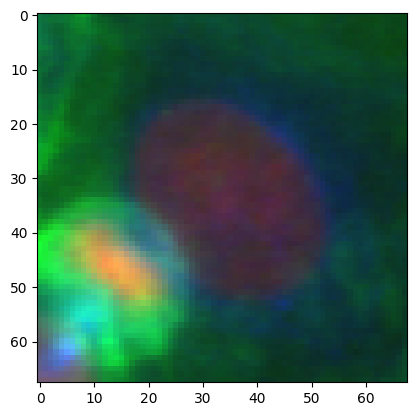

In [27]:
plot_image(img_saturate(x))

In [28]:
def sample_from_latent(latent: torch.Tensor, vae: nn.Module):
    x_reconstruction = vae.observation(latent)
    return x_reconstruction

In [29]:
random_latent = np.random.normal(1, size=256).astype(np.float32)
random_latent = torch.from_numpy(0.1 * random_latent[None])
x_reconstruction = sample_from_latent(random_latent, vae)
x_reconstruction = x_reconstruction[0]

In [30]:
vae.eval() # because of batch normalization

outputs = vae(x[None,:,:,:])
x_hat = outputs["x_hat"]

x_reconstruction = x_hat
x_reconstruction = x_reconstruction[0].detach()

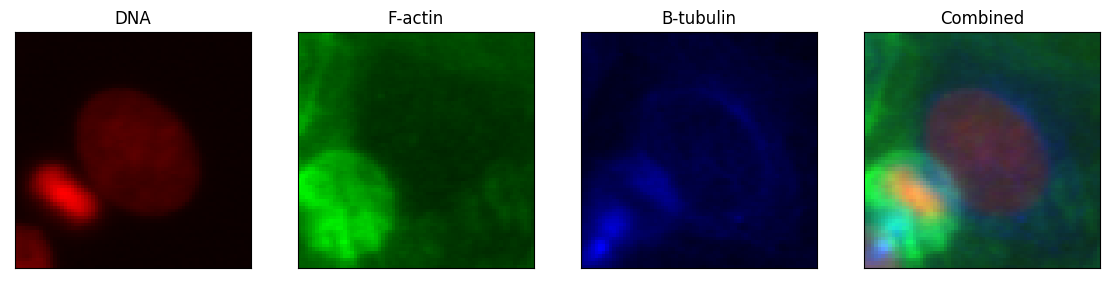

In [31]:
plot_image_channels(img_saturate(x))

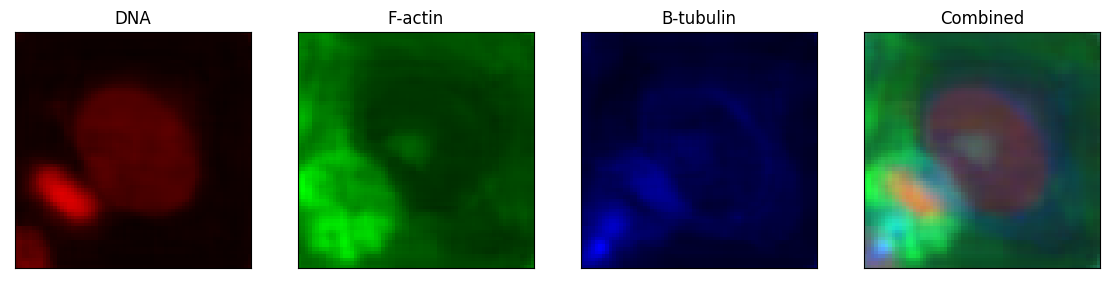

In [32]:
plot_image_channels(img_saturate(x_reconstruction))

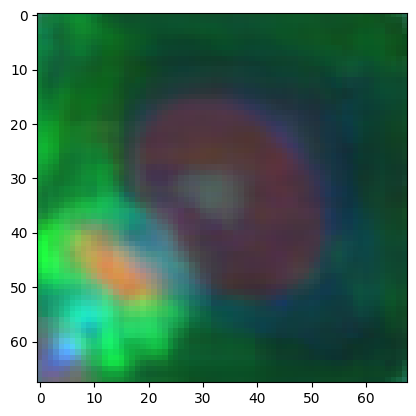

In [33]:
plot_image(img_saturate(clip_image_to_zero_one(x_reconstruction)))

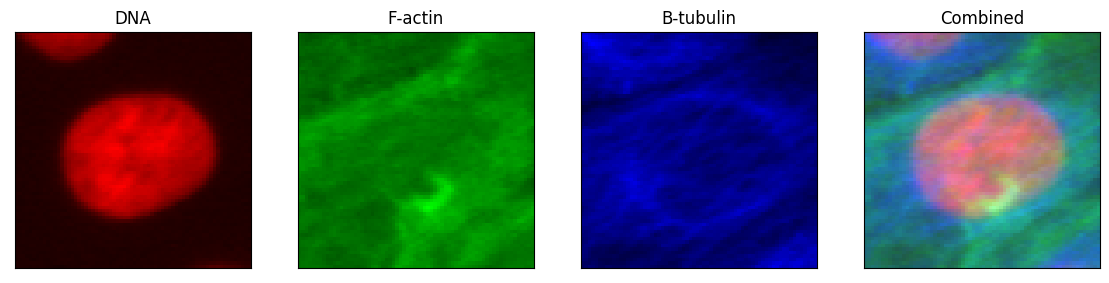

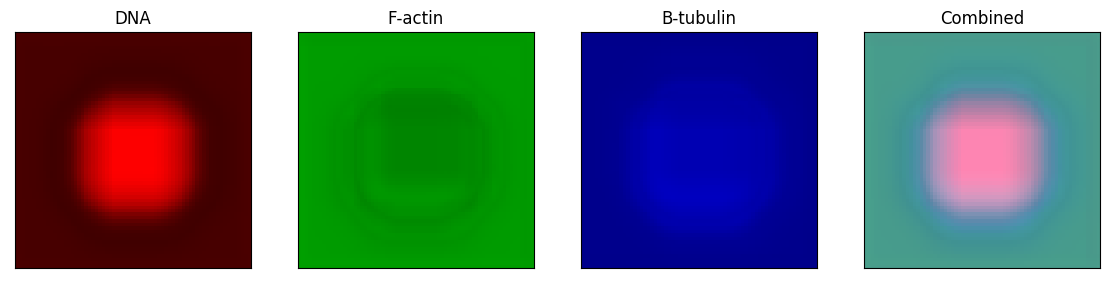

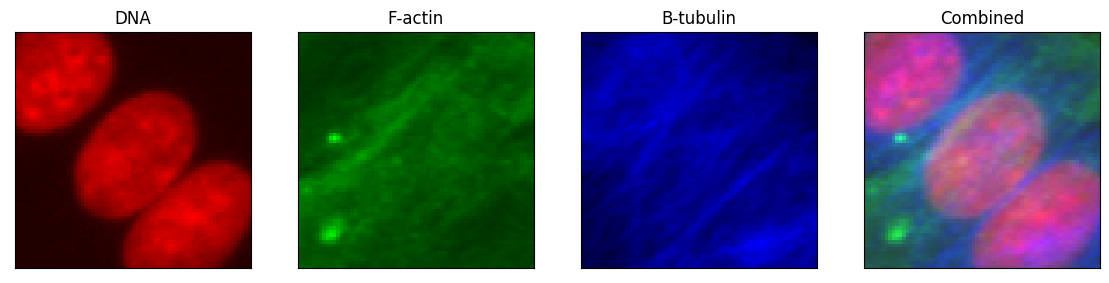

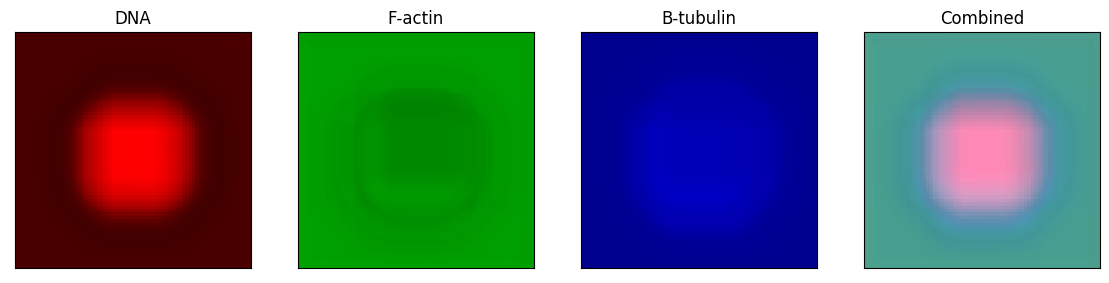

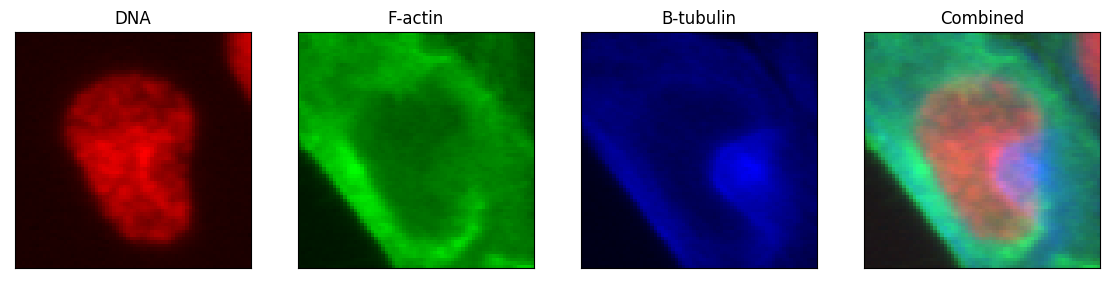

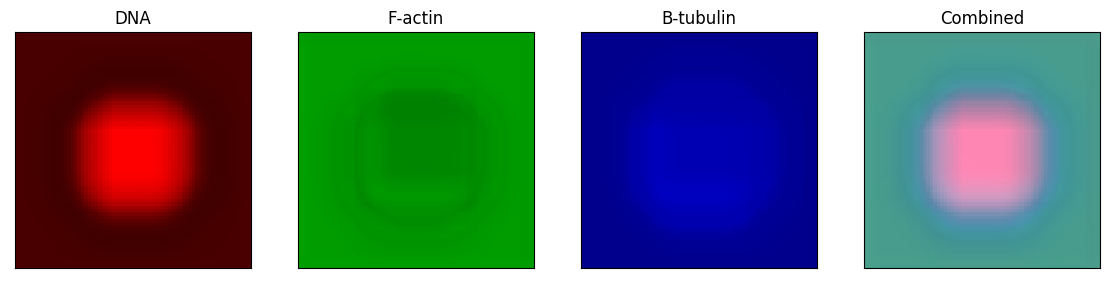

In [156]:
n = 3
for i in range(n):
    x, y = train_set[i]    
    #x = x.to(device)
    
    plot_image_channels(x)
   
    outputs = vae(x[None,:,:,:])
    x_hat = outputs["x_hat"]
    
    x_reconstruction = x_hat
    x_reconstruction = x_reconstruction[0].detach()
    plot_image_channels(img_saturate(x_reconstruction))


## Downstream Classification

In [62]:
def get_plate_and_well_indices(metadata: pd.DataFrame) -> Dict[str, list]:
    plates_and_wells = np.array(metadata[['Image_Metadata_Plate_DAPI','Image_Metadata_Well_DAPI']])
    result = defaultdict(list)

    for i in range(plates_and_wells.shape[0]):
        plate, well = plates_and_wells[i]
        result[(plate, well)] += [i]
        
    return result

In [63]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, n_classes: int = 13):
        super(NeuralNetwork, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes))

    def forward(self, x):
        logits = self.net(x)
        return logits

N_classes = len(mapping)
classifier = NeuralNetwork(N_classes).to(device)
print(classifier)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=13, bias=True)
  )
)


In [64]:
# VAE
image_shape = np.array([3, 68, 68])
latent_features = 256
vae = CytoVariationalAutoencoder(image_shape, latent_features).to(device) # @TODO: load trained parameters

In [65]:
def extract_well_metadata(metadata: pd.DataFrame, plate_and_well_indices: Dict[Tuple[str, str], list]) -> pd.DataFrame:
    data = defaultdict(list)

    for plate_and_well in plate_and_well_indices:
        indices = plate_and_well_indices[plate_and_well]
        index = indices[0] # just use the first sample, since they all have undergone the same treatment

        row = metadata.loc[index]
        
        plate, well = plate_and_well
        
        data["Image_Metadata_Plate_DAPI"] += [plate]
        data["Image_Metadata_Well_DAPI"] += [well]
        data["Image_Metadata_Compound"] += [row["Image_Metadata_Compound"]]
        data["Image_Metadata_Concentration"] += [row["Image_Metadata_Concentration"]]
        data["moa"] += [row["moa"]]

    well_metadata = pd.DataFrame(data)
        
    return well_metadata

In [176]:
def get_all_representations(vae: nn.Module, metadata: pd.DataFrame, images: torch.Tensor) -> torch.Tensor:
    all_repr = torch.empty((len(metadata), vae.latent_features))
    with torch.no_grad():
        vae.eval()
        batch_size = 64
        batch_offset = np.arange(start=0, stop=len(metadata), step=batch_size)
        for j in range(batch_offset.shape[0] - 1):
            start = batch_offset[j]
            end = batch_offset[j+1]
            output = vae(images[start:end, :,:])
            all_repr[start:end,:] = output["z"]
            
        # last batch        
        outputs = vae(images[batch_offset[-1]:len(metadata),:])
        all_repr[batch_offset[-1]:len(metadata), :] = outputs["z"]
    return all_repr

In [177]:
all_represenatations = get_all_representations (vae, metadata, images)

In [178]:
def get_well_profiles_from_repr(vae: nn.Module, metadata: pd.DataFrame, all_representations: torch.Tensor) -> torch.Tensor:
    plate_and_well_indices = get_plate_and_well_indices(metadata)
    well_metadata = extract_well_metadata(metadata, plate_and_well_indices)
    well_profiles = torch.empty((len(plate_and_well_indices), vae.latent_features))
    
    with torch.no_grad():
        vae.eval()
        
        for i, plate_and_well in enumerate(plate_and_well_indices):
            indices = plate_and_well_indices[plate_and_well]
            well_profiles[i] = all_representations.sum(axis=0) / all_representations.shape[0] # average over each well

    return well_profiles, well_metadata

In [179]:
def get_well_profiles(vae: nn.Module, metadata: pd.DataFrame, images: torch.Tensor) -> torch.Tensor:
    plate_and_well_indices = get_plate_and_well_indices(metadata)
    well_metadata = extract_well_metadata(metadata, plate_and_well_indices)
    
    well_profiles = torch.empty((len(plate_and_well_indices), vae.latent_features))
    
    batch_size = 64 # we need to batch them to handle memory issues...
    
    with torch.no_grad():
        vae.eval()
        
        for i, plate_and_well in enumerate(plate_and_well_indices):
            indices = plate_and_well_indices[plate_and_well]
            x = images[indices]
            x = x.to(device)

            z = torch.zeros(vae.latent_features)

            batch_offset = np.arange(start=0, stop=len(x), step=batch_size)
            for j in range(batch_offset.shape[0] - 1):
                start = batch_offset[j]
                end = batch_offset[j+1]

                outputs = vae(x[start:end])
                z += torch.sum(outputs["z"])

            # last batch
            outputs = vae(x[batch_offset[-1]:])   
            z += torch.sum(outputs["z"])

            well_profiles[i] = z.detach().cpu() / len(indices) # average over each well
        
    return well_profiles, well_metadata

In [180]:
%%time
well_profiles, well_metadata = get_well_profiles_from_repr(vae, metadata, all_represenatations)

CPU times: user 15.8 ms, sys: 15.4 ms, total: 31.2 ms
Wall time: 17.3 ms


In [95]:
well_metadata

,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Image_Metadata_Compound,Image_Metadata_Concentration,moa
0,Week5_29321,C02,DMSO,0.00,DMSO
1,Week10_40119,B02,DMSO,0.00,DMSO
2,Week7_34641,C11,taxol,0.30,Microtubule stabilizers
3,Week3_25461,B09,vincristine,0.01,Microtubule destabilizers
4,Week10_40119,C02,DMSO,0.00,DMSO
...,...,...,...,...,...
745,Week1_22123,D03,taxol,3.00,Microtubule stabilizers
746,Week4_27821,B03,cyclohexamide,50.00,Protein synthesis
747,Week4_27801,B11,taxol,0.30,Microtubule stabilizers
748,Week8_38203,C08,camptothecin,0.03,DNA replication


In [69]:
def count_num_correct(y_pred, y_true):
    return torch.sum(y_pred == y_true).item()

In [70]:
# Classifier
N_classes = len(mapping)
classifier = NeuralNetwork(N_classes).to(device)

# Training
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-2)

num_epochs = 10
batch_size = 32

In [71]:
def extract_metadata_with_compound(metadata: pd.DataFrame, compound: str) -> pd.DataFrame:
    return metadata[metadata["Image_Metadata_Compound"] == compound]

In [72]:
def remove_metadata_subset(metadata: pd.DataFrame, subset: pd.DataFrame) -> pd.DataFrame:
    return metadata[~metadata.index.isin(subset.index)]

In [73]:
metadata_test = extract_metadata_with_compound(well_metadata, "taxol")
metadata_train_all = remove_metadata_subset(well_metadata, metadata_test)
metadata_train, metadata_validation = split_metadata(metadata_train_all, split_fraction = .49)

mapping = get_MOA_to_id()
train_set = SingleCellDataset(metadata_train, well_profiles, mapping)
validation_set = SingleCellDataset(metadata_validation, well_profiles, mapping)
test_set = SingleCellDataset(metadata_test, well_profiles, mapping)

In [74]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0, drop_last=False)
validation_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=0, drop_last=False)

In [75]:
train_loss = []
train_accuracy = []

validation_loss = []
validation_accuracy = []

for epoch in range(num_epochs):
    print(f"epoch: {epoch}/{num_epochs}")    

    train_epoch_loss = []
    train_epoch_accuracy = []
    
    classifier.train()
    
    train_correct = 0
    train_num_predictions = 0
    
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        prediction_prob = classifier(x)
        loss = loss_fn(prediction_prob, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        N = len(x)
        train_num_predictions += N
        pred = torch.argmax(prediction_prob, dim=1)
        train_correct += count_num_correct(pred, y.detach())
        
        train_epoch_loss.append(loss.detach().item())
        
    epoch_mean_loss = np.mean(train_epoch_loss)
    train_loss.append(epoch_mean_loss)
    train_accuracy.append(train_correct / train_num_predictions)
    
    print("training | loss: {:.2f}".format(epoch_mean_loss))
    
    
    validation_epoch_loss = []
    classifier.eval()
    
    validation_correct = 0
    validation_num_predictions = 0
    
    for x, y in validation_loader:
        x = x.to(device)
        y = y.to(device)
        
        prediction_prob = classifier(x)
        loss = loss_fn(prediction_prob, y)
        
        validation_epoch_loss.append(loss.detach().item())
        
        N = len(x)
        validation_num_predictions += N
        pred = torch.argmax(prediction_prob, dim=1)
        validation_correct += count_num_correct(pred, y)

    epoch_mean_loss = np.mean(validation_epoch_loss)
    validation_loss.append(epoch_mean_loss)
    validation_accuracy.append(validation_correct / validation_num_predictions)
   
        
    print("validation | loss: {:.2f}".format(epoch_mean_loss))

epoch: 0/10
training | loss: 2.28
validation | loss: 2.41
epoch: 1/10
training | loss: 2.12
validation | loss: 2.70
epoch: 2/10
training | loss: 2.10
validation | loss: 2.68
epoch: 3/10
training | loss: 2.12
validation | loss: 2.44
epoch: 4/10
training | loss: 2.00
validation | loss: 2.85
epoch: 5/10
training | loss: 2.06
validation | loss: 2.50
epoch: 6/10
training | loss: 1.96
validation | loss: 2.84
epoch: 7/10
training | loss: 1.97
validation | loss: 2.78
epoch: 8/10
training | loss: 2.02
validation | loss: 2.57
epoch: 9/10
training | loss: 2.05
validation | loss: 2.39


In [76]:
def plot_classifier_performance(train_loss, train_accuracy, validation_loss, validation_accuracy):
    fig, axs = plt.subplots(1, 2, figsize=(14,6), constrained_layout = True)
    fig.suptitle("Classifier - learning", fontsize=16)

    ax1 = axs[0]
    ax1.grid()
    ax1.plot(train_loss)
    ax1.plot(validation_loss)
    ax1.legend(["train", "validation"])
    ax1.set_ylabel("loss")
    ax1.set_xlabel("epoch")

    ax2 = axs[1]
    ax2.grid()
    ax2.plot(train_accuracy)
    ax2.plot(validation_accuracy)
    ax2.legend(["train", "validation"])
    ax2.set_ylabel("accuracy")
    ax2.set_xlabel("epoch")

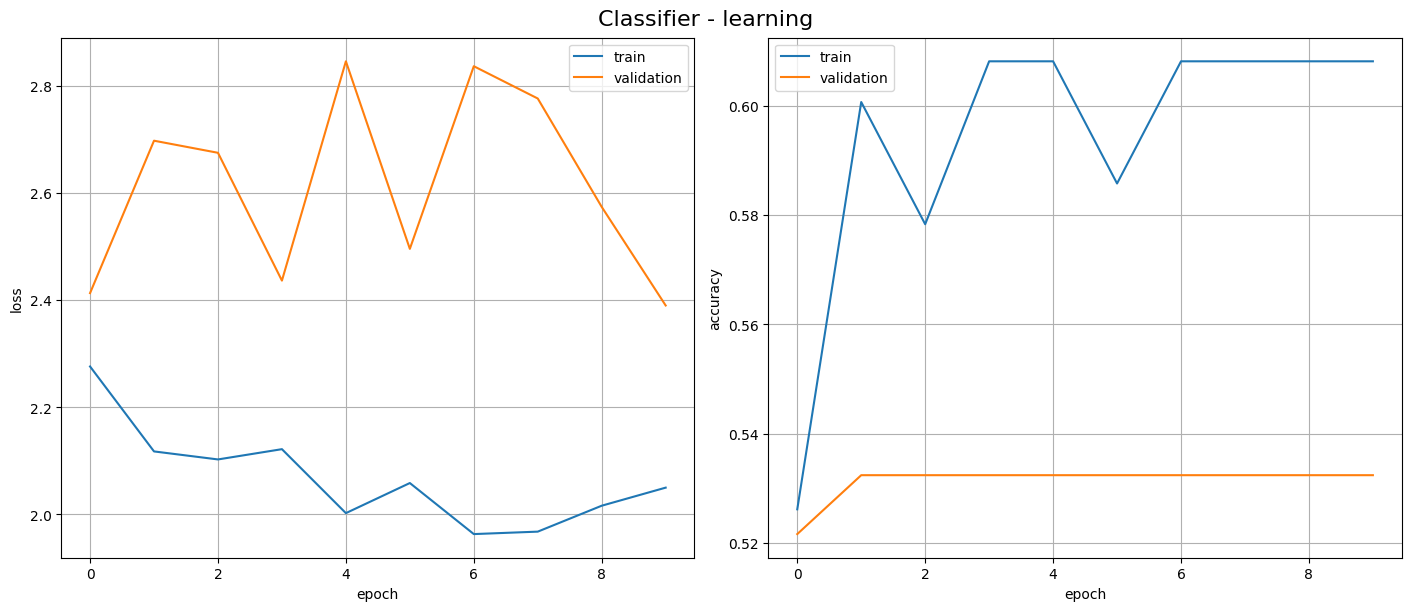

In [77]:
plot_classifier_performance(train_loss, train_accuracy, validation_loss, validation_accuracy)

## @TODO
- Look at latent representation
    - How does changing one latent variable change the image reconstruction?
    - How similiar are images in the latent space (cosine-simularity)

In [78]:
def print_MOA_distribution(metadata: pd.DataFrame):
    moa_types = get_MOA_types()
    for moa in moa_types:
        count = np.sum(metadata["moa"] == moa)
        percentage = count / len(metadata)
        print("{} - {:.3f}".format(moa, percentage))

In [79]:
def extract_indices_for_each_MOA(metadata: pd.DataFrame) -> Dict[str, np.ndarray]:
    moa_types = get_MOA_types()
    result = {}
    
    for moa in moa_types:
        mask = np.array(metadata["moa"] == moa)
        result[moa] = np.array(metadata.index[mask])
        
    return result

In [80]:
def flatten_MOA_indices(moa_indices: Dict[str, np.ndarray]):
    return np.concatenate([moa_indices[moa] for moa in moa_indices])

In [81]:
def extract_metadata_from_indices(metadata: pd.DataFrame, indices: np.ndarray) -> pd.DataFrame:
    return metadata.loc[indices]

In [82]:
def shuffle_MOA_indices_inplace(moa_indices: Dict[str, np.ndarray]):
    for moa in moa_indices:
        np.random.shuffle(moa_indices[moa])

In [83]:
def count_MOA_samples(metadata: pd.DataFrame):
    moa_types = get_MOA_types()
    indices = extract_indices_for_each_MOA(metadata)
    result = {}
    
    for moa in indices:
        result[moa] = indices[moa].shape[0]
        
    return result

In [84]:
def get_MOA_types() -> List[str]:
    return list(get_MOA_to_id())

In [85]:
class MoaBalancedBatchGenerator:
    
    def __init__(self, moa_indices: Dict[str, np.ndarray], images: torch.Tensor, metadata: pd.DataFrame, num_moa_type_per_batch: int = 1):
        self.moa_indices = moa_indices
        self.batch_size = num_moa_type_per_batch * len(moa_indices)
        self.num_moa_type_per_batch = num_moa_type_per_batch
        self.images = images
        self.metadata = metadata
    
    def next_indices(self) -> np.ndarray:
        result = np.empty(self.batch_size, dtype=np.int64)
        
        for i, moa in enumerate(moa_indices):
            pick = np.random.choice(moa_indices[moa], self.num_moa_type_per_batch, replace=False)
            
            start = i * self.num_moa_type_per_batch
            end = start + self.num_moa_type_per_batch
            result[start:end] = pick
            
        return result
    
    def __iter__(self):
        return self

    def __next__(self):
        indices = self.next_indices()
        X, y = extract_batch_from_indices(indices, self.images, self.metadata)
        return X, y

In [86]:
def get_MOA_balanced_metadata_subset(all_metadata: pd.DataFrame, num_samples_in_each_moa: int) -> pd.DataFrame:
    moa_indices = extract_indices_for_each_MOA(all_metadata)
    
    for moa in moa_indices:
        assert len(moa_indices[moa]) >= num_samples_in_each_moa, "MOA {} has only {} samples, but asked for {} samples".format(moa, len(moa_indices[moa]), num_samples_in_each_moa)
        moa_indices[moa] = moa_indices[moa][:num_samples_in_each_moa]
    
    indices = flatten_MOA_indices(moa_indices)
    metadata = extract_metadata_from_indices(all_metadata, indices)
    
    return metadata

In [87]:
metadata = get_MOA_balanced_metadata_subset(metadata_all, num_samples_in_each_moa=20)
metadata = metadata.reset_index(drop=True)

In [90]:
print_MOA_distribution(metadata)

Actin disruptors - 0.077
Aurora kinase inhibitors - 0.077
Cholesterol-lowering - 0.077
DMSO - 0.077
DNA damage - 0.077
DNA replication - 0.077
Eg5 inhibitors - 0.077
Epithelial - 0.077
Kinase inhibitors - 0.077
Microtubule destabilizers - 0.077
Microtubule stabilizers - 0.077
Protein degradation - 0.077
Protein synthesis - 0.077


In [91]:
metadata_test = get_MOA_balanced_metadata_subset(metadata, num_samples_in_each_moa=2)
metadata_train_all = metadata[~metadata.index.isin(metadata_test.index)]
metadata_validation = get_MOA_balanced_metadata_subset(metadata_train_all, num_samples_in_each_moa=2)
metadata_training = metadata_train_all[~metadata_train_all.index.isin(metadata_validation.index)]

In [92]:
#moa_indices = extract_indices_for_each_MOA(metadata_training)
#shuffle_MOA_indices_inplace(moa_indices)

In [93]:
moa_indices = extract_indices_for_each_MOA(metadata_training)
batchGenerator = MoaBalancedBatchGenerator(moa_indices, images, metadata, num_moa_type_per_batch=4)

In [94]:
%%time
max_iterations = 80_000

i = 0
for i in range(max_iterations):
    X, y = next(batchGenerator)
    

print("done")

done
CPU times: user 38 s, sys: 16.1 s, total: 54.1 s
Wall time: 25.8 s
